In [1]:
# OBJECTIVES:
# Testing if the mobilnet/efficient net have similar ap scores (using new pipeline)
# Testing the tesing script in py

In [38]:
from pathlib import Path
import pandas as pd
from datetime import datetime
import glob
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import numpy as np

In [3]:
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [4]:
# important directories
result_root = r'/Users/krish/ljmu/3.results/20112022-testing_mobilnet_in_new_pipeline/'
Path(result_root).mkdir(parents=True, exist_ok=True)
root_path =  r'/Users/krish/ljmu/1.data/afo/'

In [5]:
# I can replace this entire cell by saving a csv but I continue to use this so that I can make changes.
# And running this hardly takes 1 sec
# Creating the dataframe for training (bettter than saving and reopening csv)
df_true = pd.DataFrame(columns = ['file_name','humans'])
df_false = pd.DataFrame(columns = ['file_name','humans'])

df_true['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv2/train/ts/*.jpg')
df_true.humans = 1

df_false['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv2/train/false/*.jpg')
df_false.humans = 0

tiled_train = df_true.append(df_false)
tiled_train['humans'] = tiled_train.humans.apply(lambda x: str(x))

# Train validation split
train_df, valid_df = train_test_split(tiled_train, 
                                   test_size = 0.15, 
                                   random_state = 1998,
                                   stratify = tiled_train['humans']) # Stratify makes sure that the subset of training and testing data returned keeps the same class propotion of the main dataframe
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 39695 validation 7005


/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_55412/479706516.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tiled_train = df_true.append(df_false)


In [6]:
# Rotation_range - random rotation within the angle mentioned
# Random_shifts - shifts 20% at max. to the horizontal and vertical(reduce to 10% as already diverse data)
# Random_flip - random flips 
# fill_mode - fill the blank pixels, when augmenting with the nearest color
datagen = ImageDataGenerator(rotation_range = 360,
                             width_shift_range=0.1, height_shift_range=0.1,
                             #horizontal_flip=True, vertical_flip=True, # Isnt much useful for us
                             brightness_range=[0.5,1.5],
                             rescale=1./255.,fill_mode='nearest')

train_generator = datagen.flow_from_dataframe(dataframe=train_df, x_col = 'file_name', y_col = 'humans', class_mode='binary', target_size=(224 , 224), batch_size=24)
valid_generator = datagen.flow_from_dataframe(dataframe=valid_df, x_col = 'file_name', y_col = 'humans', class_mode='binary', target_size=(224 , 224), batch_size=24)

Found 39695 validated image filenames belonging to 2 classes.
Found 7005 validated image filenames belonging to 2 classes.


In [7]:
# i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer
# (224,224,3) is the default shape for imagent and that actually cant bechanged
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False, 
                                           weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))



model.add(Dense(1, activation="sigmoid" , name="classification"))

Metal device set to: Apple M1


2022-11-20 21:28:55.941556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-20 21:28:55.941972: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.004,momentum=0.9), 
            loss='BinaryCrossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1024)              5

In [9]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.5)
class_weight = {0:train_df['humans'].value_counts()[0]/train_df.shape[0],1:train_df['humans'].value_counts()[1]/train_df.shape[0],}

In [10]:
history = model.fit(train_generator, validation_data = valid_generator, epochs = 20, class_weight=class_weight,callbacks=[es])

Epoch 1/20


2022-11-20 21:28:56.656965: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-20 21:28:57.305432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1654/1654 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9062

2022-11-20 21:39:02.204106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1654/1654 [==============================] - 670s 404ms/step - loss: 0.0950 - accuracy: 0.9062 - val_loss: 0.2000 - val_accuracy: 0.9360
Epoch 2/20
1654/1654 [==============================] - 660s 399ms/step - loss: 0.0722 - accuracy: 0.9337 - val_loss: 0.1921 - val_accuracy: 0.9385
Epoch 3/20
1654/1654 [==============================] - 673s 407ms/step - loss: 0.0675 - accuracy: 0.9366 - val_loss: 0.1822 - val_accuracy: 0.9423
Epoch 4/20
1654/1654 [==============================] - 740s 447ms/step - loss: 0.0637 - accuracy: 0.9415 - val_loss: 0.1701 - val_accuracy: 0.9449


In [13]:
now = datetime.now()
date_time = now.strftime("%d%m%Y-%H%M")
model_save_dir = result_root+date_time+'-Mobilenet+tile+augmentation_20epochs_afo'
model.save(model_save_dir)

INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/20112022-testing_mobilnet_in_new_pipeline/20112022-2214-Mobilenet+tile+augmentation_20epochs_afo/assets


INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/20112022-testing_mobilnet_in_new_pipeline/20112022-2214-Mobilenet+tile+augmentation_20epochs_afo/assets


292/292 - 54s - loss: 0.1725 - accuracy: 0.9430 - 54s/epoch - 185ms/step


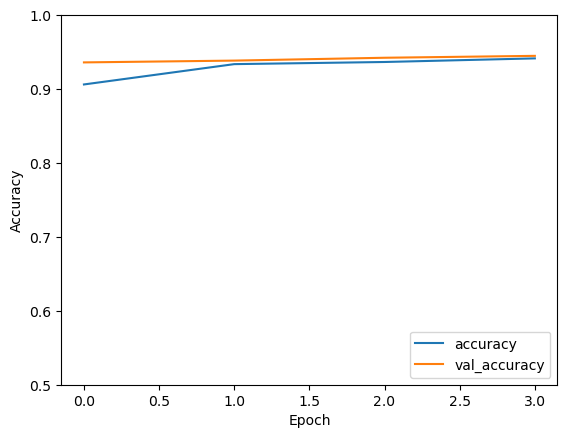

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(valid_generator, verbose=2)

## tester

In [32]:
df_true = pd.DataFrame(columns = ['file_name','humans'])
df_false = pd.DataFrame(columns = ['file_name','humans'])

df_true['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/*.jpg')
df_true['humans'] = 1

df_false['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv2/test/false/*.jpg')
df_false['humans'] = 0

tiled_test = df_true.append(df_false)

tiled_test['humans'] = tiled_test['humans'].apply(lambda x: str(x))

IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([layers.Resizing(IMG_SIZE, IMG_SIZE),layers.Rescaling(1./255)])

model = tf.keras.models.load_model(model_save_dir)


def predicter(file_path):
    
    #print(file_path)
    im = Image.open(file_path)
    test_input = np.array(im, dtype=np.uint8)
    if len(test_input.shape) == 3:
        test_input = resize_and_rescale(test_input)
        out = model(tf.reshape(test_input,(1,224,224,3)))

        return np.array(out)[0][0] 
    else:
        return 'out_of_shape'
    


/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_55412/834701717.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tiled_test = df_true.append(df_false)


In [43]:
if os.path.exists(model_save_dir+'test_prediction.csv'):
    tiled_test=pd.read_csv(model_save_dir+'test_prediction.csv')
    y_true = tiled_test.iloc[:]['humans'].values
    y_pred = tiled_test.iloc[:]['prediction'].values

else:    
    tiled_test['prediction'] = tiled_test.file_name.apply(predicter)
    tiled_test['humans'] = tiled_test.humans.apply(lambda x:int(x)) 
    tiled_test.to_csv(model_save_dir+'test_prediction.csv')
    y_true = tiled_test.iloc[:]['humans'].values
    y_pred = tiled_test.iloc[:]['prediction'].values

In [29]:
import sys  
sys.path.insert(0, r'/Users/krish/ljmu/2.code')

import metrics_tester as mt

In [30]:
mt2.model_imp(model_save_dir)
y_pred, y_true = mt2.prediction_csv(model_save_dir)

AttributeError: module 'metrics_tester' has no attribute 'model_imp'

In [44]:
from sklearn.metrics import confusion_matrix
print('confusion',confusion_matrix(y_true,y_pred.round()))

from sklearn.metrics import recall_score
print('recall',recall_score(y_true,y_pred.round()))

from sklearn.metrics import precision_score
print('precision',precision_score(y_true,y_pred.round()))

confusion [[11115   100]
 [  556  3932]]
recall 0.8761140819964349
precision 0.9751984126984127


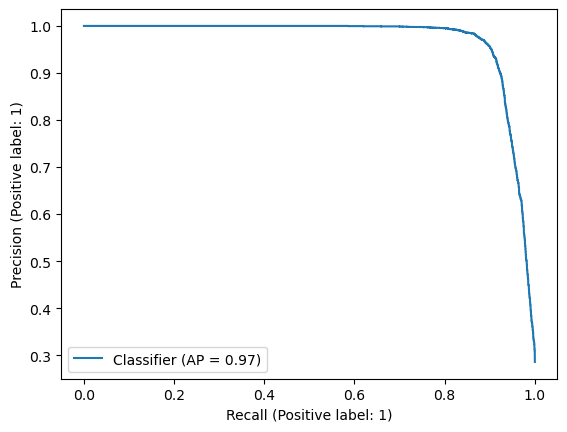

In [45]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_true,y_pred)